# ATMS 523 Homework 5
## Wenhan Tang (UIN: 678054985)

### Import packages

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Task 1. Split the data into a 70-30 split for training and testing data.

In [2]:
df = pd.read_csv("radar_parameters.csv")
X = df[ ['Zh (dBZ)', 'Zdr (dB)', 'Ldr (dB)', 'Kdp (deg km-1)', 'Ah (dBZ/km)', 'Adr (dB/km)'] ]
y = df[ ['R (mm/hr)'] ]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Task 2. Using the split created in (1), train a multiple linear regression dataset using the training dataset, and validate it using the testing dataset.  Compare the $R^2$ and root mean square errors of model on the training and testing sets to a baseline prediction of rain rate using the formula $Z = 200 R^{1.6}$.

In [4]:
# Create a linear regression model.
model = LinearRegression()
# Fit it with training data.
model.fit(X_train, y_train)

# Predict precipitation rate for train and test data using linear model.
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [5]:
# Define validation function (R2 & RMSE)
def validation(y_pred, y_true):
    vali = {}
    vali["R2"] = r2_score(y_pred, y_true)
    vali["RMSE"] = mean_squared_error(y_pred, y_true) ** 0.5
    return vali

# Validate the linear regression model.
vali_train = validation(y_pred_train, y_train.values)
vali_test = validation(y_pred_test, y_test.values)
print("Linear model on the train set:")
print(vali_train)
print("Linear model on the test set:")
print(vali_test)

Linear model on the train set:
{'R2': 0.9887057748396983, 'RMSE': 0.9148293314015452}
Linear model on the test set:
{'R2': 0.9865675858573243, 'RMSE': 0.9583564653829776}


In [6]:
# The baseline model.
def baseline_model(X):
    Zh = X['Zh (dBZ)'].values
    Z = 10**(Zh / 10)
    R = (Z / 200) ** (1/1.6)
    return R

In [7]:
# Predict precipitation rate using the baseline model.
y_pred = baseline_model(X)
vali_base = validation(y_pred, y)

# validate the baseline model.
vali_train_base = validation(baseline_model(X_train), y_train)
vali_test_base = validation(baseline_model(X_test), y_test)
print("Baseline model on the train dataset")
print(vali_train_base)
print("Baseline model on the train dataset")
print(vali_test_base)
print("Baseline model on the whole dataset")
print(vali_base)

Baseline model on the train dataset
{'R2': 0.24323952742000354, 'RMSE': 7.072457766822082}
Baseline model on the train dataset
{'R2': 0.23518915998899093, 'RMSE': 7.3523877227693095}
Baseline model on the whole dataset
{'R2': 0.2407320902415906, 'RMSE': 7.157590840042378}


### Task 3. Repeat 1 doing a grid search over polynomial orders, using a grid search over orders 0-9, and use cross-validation of 7 folds.  For the best polynomial model in terms of $R^2$, does it outperform the baseline and the linear regression model in terms of $R^2$ and root mean square error?

In [8]:
# Define the pipline for polynomial model.
pipeline = Pipeline([
    ('PF', PolynomialFeatures()),
    ('LR', LinearRegression())
])
# Define the parameter space (degree: 0->9).
parameters_grid = {
    'PF__degree': np.arange(10),
}
# Grid search.
grid = GridSearchCV(pipeline, parameters_grid, cv=7)
grid.fit(X, y)

,estimator,Pipeline(step...egression())])
,param_grid,"{'PF__degree': array([0, 1, ..., 6, 7, 8, 9])}"
,scoring,None
,n_jobs,None
,refit,True
,cv,7
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,np.int64(5)


In [9]:
# Creat a polynomial model based on the best parameter.
degree_best = grid.best_params_["PF__degree"]
model_best = Pipeline([
    ('PF', PolynomialFeatures(degree=degree_best)),
    ('LR', LinearRegression())
])
# Fit the model using training data.
model_best.fit(X_train, y_train)
y_pred_train_best = model_best.predict(X_train)
y_pred_test_best = model_best.predict(X_test)

# Validate the polynomial model with the best parameter.
vali_train_best = validation(y_pred_train_best, y_train)
vali_test_best = validation(y_pred_test_best, y_test)

In [10]:
# The performance of the best polynomial model.
print("The best polynomial model on the train set:")
print(vali_train_best)
print("The best polynomial model on the test set:")
print(vali_test_best)

The best polynomial model on the train set:
{'R2': 0.9999991361907058, 'RMSE': 0.008045617324918387}
The best polynomial model on the test set:
{'R2': 0.9999963297908553, 'RMSE': 0.016017084247091348}


**Answer for Question 3:**  Yes, the polynomial model with a degree of 5 performs better than both the baseline and linear models in terms of $R^2$ and RMSE.

### Task 4. Repeat 1 with a Random Forest Regressor, and perform a grid_search on the following parameters:
   
   ```python
   param_grid = {
    "bootstrap": [True, False],
    "max_depth": [10, 100],
    "max_features": ["sqrt", 1.0],  
    "min_samples_leaf": [1, 4],
    "min_samples_split": [2, 10],
    "n_estimators": [200, 1000]}
   ```
  Can you beat the baseline, or the linear regression, or best polynomial model with the best optimized Random Forest Regressor in terms of $R^2$ and root mean square error?

In [11]:
# Define a random forest model.
rf_model = RandomForestRegressor()

# Parameter space.
param_grid = {
 "bootstrap": [True, False],
 "max_depth": [10, 100],
 "max_features": ["sqrt", 1.0],  
 "min_samples_leaf": [1, 4],
 "min_samples_split": [2, 10],
 "n_estimators": [200, 1000]

# Grid search.
grid_rf = GridSearchCV(rf_model, param_grid, cv=3, n_jobs=-1)
grid_rf.fit(X, y.values.flatten())

# Show the best parameters for the random forest model. 
print("The parameters for the best random forest model")
print(grid_rf.best_params_)

The parameters for the best random forest model
{'bootstrap': True, 'max_depth': 100, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [15]:
# Creat a random forest model using the best parameters.
rf_best = RandomForestRegressor(
    bootstrap=True,
    max_depth=100,
    max_features=1.0,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
)
# Fit the random forest model using training data.
rf_best.fit(X_train, y_train.values.flatten())
y_pred_train_rf = rf_best.predict(X_train)
y_pred_test_rf = rf_best.predict(X_test)

# Validate the random forest model with the best parameters.
vali_train_rf = validation(y_pred_train_rf, y_train.values)
vali_test_rf = validation(y_pred_test_rf, y_test.values)

In [16]:
# Performance of the best random forest mdoel.
print("The best random forest model on the train set:")
print(vali_train_rf)
print("The best random forest model on the test set:")
print(vali_test_rf)

The best random forest model on the train set:
{'R2': 0.9960854636806357, 'RMSE': 0.5331626795382415}
The best random forest model on the test set:
{'R2': 0.9444282402669699, 'RMSE': 1.911938513311007}


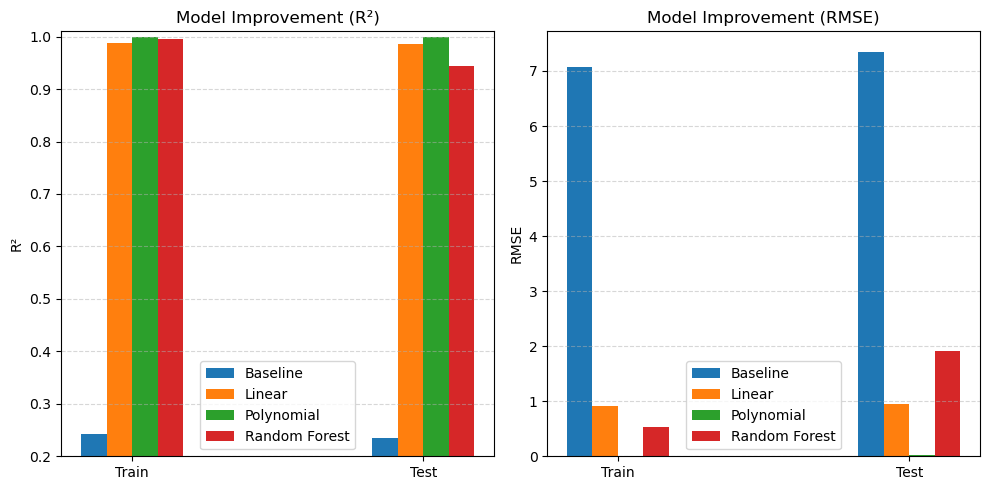

In [17]:
# Visualization of models performance comparison.
metrics = ["Train", "Test"]
r2_base = [vali_train_base["R2"], vali_test_base["R2"]]
r2_linear = [vali_train["R2"], vali_test["R2"]]
r2_poly = [vali_train_best["R2"], vali_test_best["R2"]]
r2_rf = [vali_train_rf["R2"], vali_test_rf["R2"]]

rmse_base = [vali_train_base["RMSE"], vali_test_base["RMSE"]]
rmse_linear = [vali_train["RMSE"], vali_test["RMSE"]]
rmse_poly = [vali_train_best["RMSE"], vali_test_best["RMSE"]]
rmse_rf = [vali_train_rf["RMSE"], vali_test_rf["RMSE"]]

x = np.arange(len(metrics))
width = 0.35 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.bar(x - width/8*3, r2_base, width/4, label="Baseline")
ax1.bar(x - width/8, r2_linear, width/4, label="Linear")
ax1.bar(x + width/8, r2_poly, width/4, label="Polynomial")
ax1.bar(x + width/8*3, r2_rf, width/4, label="Random Forest")
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.set_ylim([0.2, 1.01])
ax1.set_ylabel("R²")
ax1.set_title("Model Improvement (R²)")
ax1.legend()
ax1.grid(axis="y", linestyle="--", alpha=0.5)


ax2.bar(x - width/8*3, rmse_base, width/4, label="Baseline")
ax2.bar(x - width/8, rmse_linear, width/4, label="Linear")
ax2.bar(x + width/8, rmse_poly, width/4, label="Polynomial")
ax2.bar(x + width/8*3, rmse_rf, width/4, label="Random Forest")
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.set_ylabel("RMSE")
ax2.set_title("Model Improvement (RMSE)")
ax2.legend()
ax2.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

**Answer for Question 4:** The random forest model with the optimal parameters outperforms the baseline model. However, it does not surpass the polynomial model in either $R^2$ or RMSE. Compared to the linear model, the random forest model shows a larger performance gap between the training and test sets and slightly lower performance in both $R^2$ and RMSE.
